# INTRODUCTION

# BUSINESS PROBLEM

Predict bad performance of workers. Focus on predicting bad performance, dont want to miss any of those. Focus on maximizing true negatives and false positives while tackling overfitting.

# IMPORTS

In [1]:
# core operational packeges
import os
import warnings

# dataset manupulation
import pandas as pd
pd.set_option('display.max_columns', 0)
import numpy as np
from IPython.display import display, HTML

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
# import plotly.graph_objs as go
# import plotly.express as px

In [2]:
# Machine Learning
# preprocessing
from sklearn import set_config
from sklearn.model_selection import train_test_split#, cross_val_predict, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
# from imblearn.over_sampling import SMOTE,SMOTENC


# model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
# # Model Explainers
# import shap
# print(shap.__version__)
# shap.initjs()

In [4]:
# custom functions loader
%load_ext autoreload
%autoreload 2
import functions as fun

# notebook styling packages
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks='True', grid='False')
## to reset to default theme
# jtplot.reset()

# OBTAIN

# SCRUB & EXPLORE

## data

In [5]:
# loading data
df = pd.read_csv('./data/garments_worker_productivity.csv')

In [6]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [7]:
df.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

In [8]:
fun.check_NaN(df)

,name,is_null,not_null
0,date,0,1197
1,quarter,0,1197
2,department,0,1197
3,day,0,1197
4,team,0,1197
5,targeted_productivity,0,1197
6,smv,0,1197
7,wip,506,691
8,over_time,0,1197
9,incentive,0,1197


In [9]:
fun.check_duplicates(df, verbose=True)

date >> number of uniques: 59
['1/1/2015' '1/3/2015' '1/4/2015' '1/5/2015' '1/6/2015' '1/7/2015'
 '1/8/2015' '1/10/2015' '1/11/2015' '1/12/2015' '1/13/2015' '1/14/2015'
 '1/15/2015' '1/17/2015' '1/18/2015' '1/19/2015' '1/20/2015' '1/21/2015'
 '1/22/2015' '1/24/2015' '1/25/2015' '1/26/2015' '1/27/2015' '1/28/2015'
 '1/29/2015' '1/31/2015' '2/1/2015' '2/2/2015' '2/3/2015' '2/4/2015'
 '2/5/2015' '2/7/2015' '2/8/2015' '2/9/2015' '2/10/2015' '2/11/2015'
 '2/12/2015' '2/14/2015' '2/15/2015' '2/16/2015' '2/17/2015' '2/18/2015'
 '2/19/2015' '2/22/2015' '2/23/2015' '2/24/2015' '2/25/2015' '2/26/2015'
 '2/28/2015' '3/1/2015' '3/2/2015' '3/3/2015' '3/4/2015' '3/5/2015'
 '3/7/2015' '3/8/2015' '3/9/2015' '3/10/2015' '3/11/2015']
____________________________________________________________
quarter >> number of uniques: 5
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
____________________________________________________________
department >> number of uniques: 3
['sweing' 'finishing ' 'fini

,name,duplicated,not_duplicated
0,date,1138,59
1,quarter,1192,5
2,department,1194,3
3,day,1191,6
4,team,1185,12
5,targeted_productivity,1188,9
6,smv,1127,70
7,wip,648,549
8,over_time,1054,143
9,incentive,1149,48


In [10]:
df.describe().transpose().style.format("{0:,.0f}")

,count,mean,std,min,25%,50%,75%,max
team,"1,197",6,3,1,3,6,9,12
targeted_productivity,"1,197",1,0,0,1,1,1,1
smv,"1,197",15,11,3,4,15,24,55
wip,691,"1,190","1,837",7,774,"1,039","1,252","23,122"
over_time,"1,197","4,567","3,349",0,"1,440","3,960","6,960","25,920"
incentive,"1,197",38,160,0,0,0,50,"3,600"
idle_time,"1,197",1,13,0,0,0,0,300
idle_men,"1,197",0,3,0,0,0,0,45
no_of_style_change,"1,197",0,0,0,0,0,0,2
no_of_workers,"1,197",35,22,2,9,34,57,89


In [11]:
# fun.df_distribution(df,color_plot='green')

## Feature engineering

### Creating target; `performance`

In [12]:
# # Multiclass target, labaled
# # empty list to hold data
# lst = []
# for x in zip(df.targeted_productivity, df.actual_productivity):
#     # % change in variables
#     delta = np.log(x[1] / x[0])
#     if delta < 0:
#         lst.append('below')
#     elif 0 <= delta < .25:
#         lst.append('met')
#     elif delta >= .25:
#         lst.append('above')
#     # error hadeler
#     else:
#         lst.append('?')
# df['performance'] = lst

In [13]:
# # binary target class, labaled
# lst = []
# for x in zip(df.targeted_productivity, df.actual_productivity):
#     # % change in variables
#     delta = np.log(x[1] / x[0])
#     if delta < 0:
#         lst.append('not_met')
#     else:
#         lst.append('met')
# df['performance'] = lst

In [14]:
# binary target class, int
lst = []
for x in zip(df.targeted_productivity, df.actual_productivity):
    # % change in variables
    delta = np.log(x[1] / x[0])
    if delta < 0:
        lst.append(0)
    else:
        lst.append(1)
df['performance'] = lst

In [15]:
# # Multiclass target, int
# # empty list to hold data
# lst = []
# for x in zip(df.targeted_productivity, df.actual_productivity):
#     # % change in variables
#     delta = np.log(x[1] / x[0])
#     if delta < 0:
#         lst.append(0)
#     elif 0 <= delta < .25:
#         lst.append(1)
#     elif delta >= .25:
#         lst.append(2)
#     # error hadeler
#     else:
#         lst.append('?')
# df['performance'] = lst

In [16]:
df.performance.value_counts()

1    875
0    322
Name: performance, dtype: int64

### binning `wip`

In [17]:
# filling NaN's with 0, meaning no wip for that session
df['wip'] = df['wip'].fillna(0)
# intervals for binning
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 150), 
                                     (150, 500), (500, 2500),
                                     (2500, 1e6)],
                                    closed='left')
# binning
wip_size = pd.cut(df['wip'].tolist(), bins=bins)
# naming categories
wip_size.categories = ['no_wip', 'small', 'med', 'large', 'xl']
# appending to df
df['wip_size'] = wip_size

### text cleaning in `department` categories 

In [18]:
# cleaning spaces
df['department'] = df['department'].str.strip()
# checking
df['department'].value_counts()

sweing       691
finishing    506
Name: department, dtype: int64

### drop features

In [19]:
df.drop(columns=['date', 'wip', 'actual_productivity'], inplace=True)

### dtype casting

In [20]:
df['quarter'] = df['quarter'].astype('category')
df['department'] = df['department'].astype('category')
df['day'] = df['day'].astype('category')
df['team'] = df['team'].astype('category')
# df['performance'] = df['performance'].astype('category')

In [21]:
df.dtypes

quarter                  category
department               category
day                      category
team                     category
targeted_productivity     float64
smv                       float64
over_time                   int64
incentive                   int64
idle_time                 float64
idle_men                    int64
no_of_style_change          int64
no_of_workers             float64
performance                 int64
wip_size                 category
dtype: object

### preparing data for model

In [22]:
df.select_dtypes('number').shape, df.select_dtypes('category').shape

((1197, 9), (1197, 5))

#### split using `sklearn`

In [23]:
X = df.drop(columns='performance').copy()
y = df['performance'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((897, 13), (897,), (300, 13), (300,))

#### OHE using `pandas`

In [25]:
pd.get_dummies(X_train).shape, pd.get_dummies(X_test).shape

((897, 38), (300, 38))

In [26]:
#### SKLEARN pipe scratch

In [27]:
# nume_cols = df.select_dtypes('number').columns.to_list()
# cate_cols = df.select_dtypes('category').columns.to_list()
# cate_cols.remove('performance')

In [28]:
# # categorical column
# # ohe = OneHotEncoder(sparse=False, drop=None)
# pipe_cate = Pipeline([
#     ('ohe' , OneHotEncoder(sparse=False, drop=None))
# ])

In [29]:
# # testing pipeline
# pd.DataFrame(pipe_cate.fit_transform(X[cate_cols]),
#              columns=pipe_cate.named_steps['ohe'].get_feature_names(cate_cols))

In [30]:
# # numerical cols
# # scaler = StandardScaler()
# pipe_nume = Pipeline([
#     ('scaler', StandardScaler())
# ])

In [31]:
# # testing pipeline
# pd.DataFrame(pipe_nume.fit_transform(X[nume_cols]),columns=nume_cols)

In [32]:
# preprocessor = ColumnTransformer([('numerical_features', pipe_nume, nume_cols),
#                                  ('categorical_features', pipe_cate, cate_cols)
#                                  ])

In [33]:
# set_config(display='text')
# display(preprocessor)

In [34]:
# pd.DataFrame(
#     preprocessor.fit_transform(X_train),
#     columns=nume_cols +
#     preprocessor.named_transformers_['categorical_features'].named_steps['ohe']
#     .get_feature_names(cate_cols).tolist()).describe().T.round(2)

In [35]:
# pd.DataFrame(
#     preprocessor.fit_transform(X_test),
#     columns=nume_cols +
#     preprocessor.named_transformers_['categorical_features'].named_steps['ohe']
#     .get_feature_names(cate_cols).tolist()).describe().T.round(2)

#### Pipelining

In [36]:
fun.df_preprocessing_pipeline(X_test,drop='first').describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
targeted_productivity,300.0,0.00,1.00,-3.63,-0.24,0.25,0.73,0.73
smv,300.0,0.00,1.00,-1.12,-1.02,0.02,0.80,3.25
over_time,300.0,0.00,1.00,-1.38,-0.96,-0.20,0.67,3.04
incentive,300.0,0.00,1.00,-0.20,-0.20,-0.10,0.03,15.95
idle_time,300.0,-0.00,1.00,-0.10,-0.10,-0.10,-0.10,12.16
idle_men,300.0,-0.00,1.00,-0.09,-0.09,-0.09,-0.09,15.76
no_of_style_change,300.0,-0.00,1.00,-0.34,-0.34,-0.34,-0.34,4.69
no_of_workers,300.0,-0.00,1.00,-1.48,-1.16,-0.03,1.01,2.46
quarter_Quarter2,300.0,0.28,0.45,0.00,0.00,0.00,1.00,1.00
quarter_Quarter3,300.0,0.17,0.38,0.00,0.00,0.00,0.00,1.00


## EDA

# MODEL

## dummy model

Class balance y_train: 
1    0.732441
0    0.267559
Name: performance, dtype: float64

Class balance y_test: 
1    0.726667
0    0.273333
Name: performance, dtype: float64

------------------------------


******************************************************************************************
Train score: 0.6076
Test score: 0.57
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    DummyClassifier(strategy='stratified')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.20      0.17      0.18        82
           1       0.70      0.74      0.72       218

    accuracy                           0.58       300
   macro avg       0.45      0.45      0.45       300
weighted avg       0.56      0.58      0.57       300

************************************************************


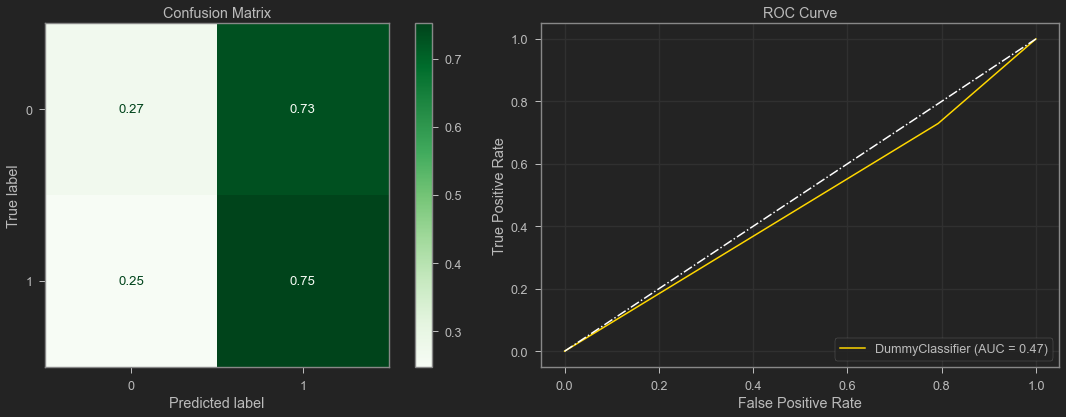

In [37]:
X_train_dummy = fun.df_preprocessing_pipeline(X_train).copy()
X_test_dummy = fun.df_preprocessing_pipeline(X_test).copy()

dummy_classifier = DummyClassifier(strategy='stratified')
print(f"""Class balance y_train: 
{y_train.value_counts(1)}
""")
print(f"""Class balance y_test: 
{y_test.value_counts(1)}
""")
print(f"""{'-'*30}""")
fun.model_report(dummy_classifier,
                 X_train=X_train_dummy,
                 y_train=y_train,
                 X_test=X_test_dummy,
                 y_test=y_test)

## logistic regression

In [38]:
X_train_log_reg = fun.df_preprocessing_pipeline(X_train, drop='first').copy()
X_test_log_reg = fun.df_preprocessing_pipeline(X_test, drop='first').copy()

******************************************************************************************
Train score: 0.7202
Test score: 0.6767
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    LogisticRegression(C=100000.0, class_weight='balanced', max_iter=1000)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.71      0.54        82
           1       0.86      0.67      0.75       218

    accuracy                           0.68       300
   macro avg       0.65      0.69      0.65       300
weighted avg       0.74      0.68      0.69       300

************************************************************


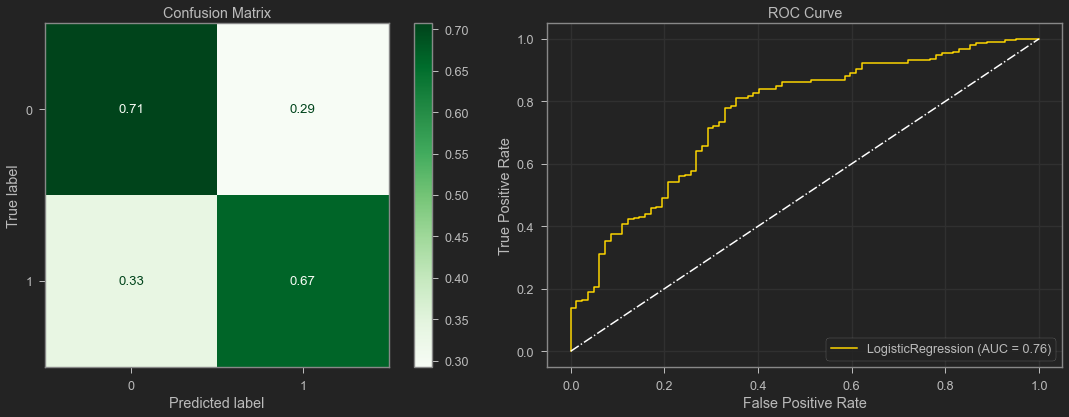

In [39]:
# logistic regression classifier
logreg = LogisticRegression(C=1e5, max_iter=1000, class_weight='balanced')
# score of logistic regression classifier
fun.model_report(logreg,
             X_train=X_train_log_reg,
             y_train=y_train,
             X_test=X_test_log_reg,
             y_test=y_test)

In [40]:
# fit logistic regression classifier to train data
logreg.fit(X_train_log_reg, y_train)
logreg.predict_proba(X_train_log_reg)

array([[0.23037106, 0.76962894],
       [0.31361695, 0.68638305],
       [0.2556652 , 0.7443348 ],
       ...,
       [0.71141916, 0.28858084],
       [0.31497379, 0.68502621],
       [0.51692088, 0.48307912]])

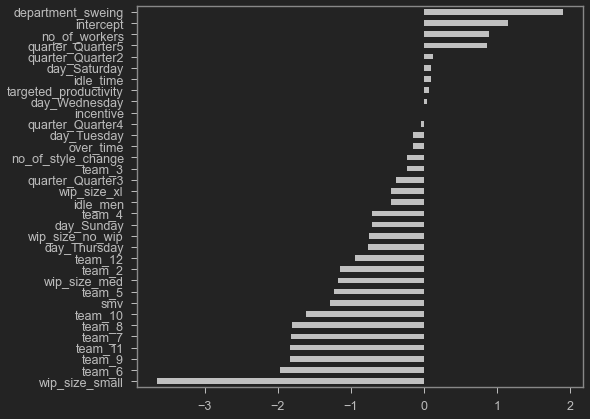

In [41]:
fun.coefficients_of_model_binary(
    logreg, X_train_log_reg, log_scale=True).sort_values().plot(kind='barh',color='silver');

### grid search with Cross Validation

In [42]:
logreg_gs = LogisticRegression(max_iter=1e4,
                               class_weight='balanced',
                               n_jobs=-1)
params = {
    'C': [.0001, .001, .01, .1, 10, 100, 1000, 10000, 1e6, 1e12],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
gridsearch_logreg = GridSearchCV(estimator=logreg_gs,
                                 param_grid=params,
                                 n_jobs=-1)
gridsearch_logreg

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000.0, n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000,
                               1000000.0, 1000000000000.0],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_logreg.fit(X_train_log_reg, y_train)
print(f"Best Parameters by gridsearch:\t{gridsearch_logreg.best_params_}")
print(f"Best Estimator by gridsearch:\t{gridsearch_logreg.best_estimator_}")

Best Parameters by gridsearch:	{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Estimator by gridsearch:	LogisticRegression(C=10, class_weight='balanced', max_iter=10000.0, n_jobs=-1,
                   solver='newton-cg')


******************************************************************************************
Train score: 0.7202
Test score: 0.68
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    LogisticRegression(C=10, class_weight='balanced', max_iter=10000.0, n_jobs=-1,
                   solver='newton-cg')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.71      0.55        82
           1       0.86      0.67      0.75       218

    accuracy                           0.68       300
   macro avg       0.65      0.69      0.65       300
weighted avg       0.75      0.68      0.70       300

************************************************************


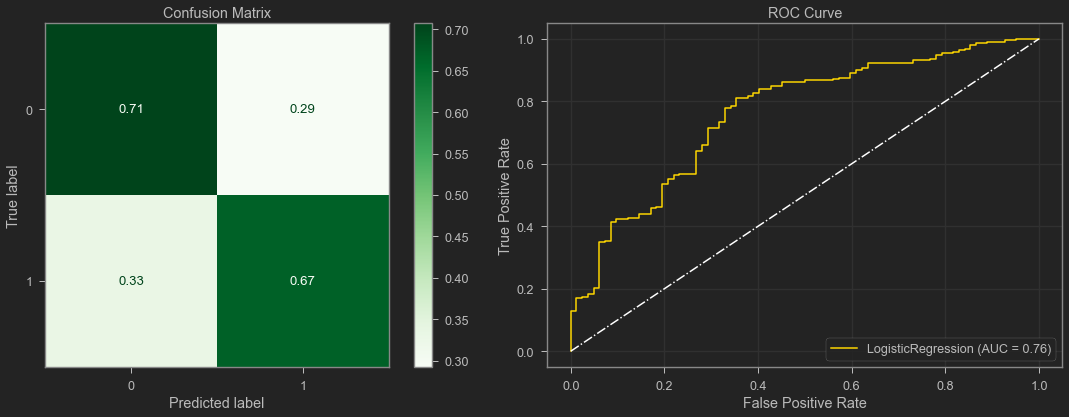

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    logreg_gs_best = gridsearch_logreg.best_estimator_
    fun.model_report(logreg_gs_best, X_train_log_reg, y_train, X_test_log_reg,
                 y_test)

## KNN

******************************************************************************************
Train score: 0.854
Test score: 0.7767
    Possible Overfitting, diffrence of scores 7.7299999999999995% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    KNeighborsClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        82
           1       0.81      0.91      0.86       218

    accuracy                           0.78       300
   macro avg       0.72      0.67      0.68       300
weighted avg       0.76      0.78      0.76       300

************************************************************


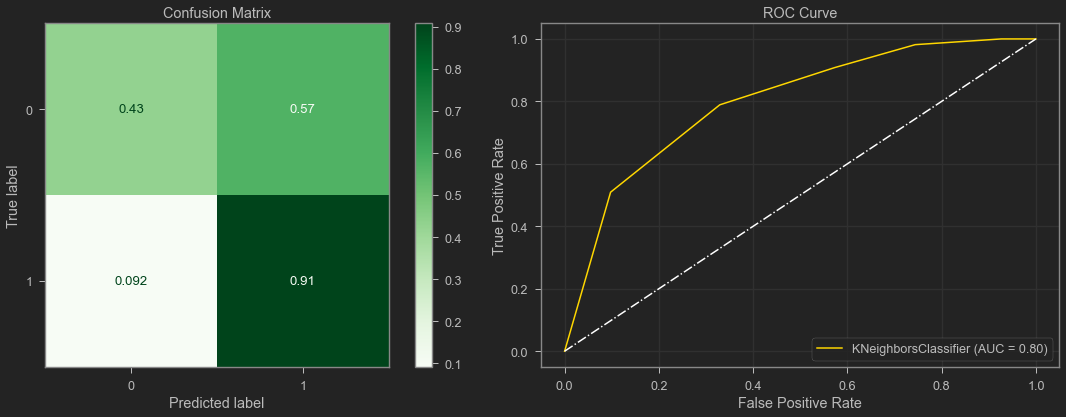

In [45]:
X_train_knn = fun.df_preprocessing_pipeline(X_train).copy()
X_test_knn = fun.df_preprocessing_pipeline(X_test).copy()

knn = KNeighborsClassifier()
fun.model_report(knn, X_train_knn, y_train, X_test_knn,
             y_test)

### grid search with Cross Validation

In [46]:
knn_gs = KNeighborsClassifier(n_jobs=-1)
params = {
    'n_neighbors': list(range(1, 21, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}
gridsearch_knn = GridSearchCV(estimator=knn_gs,
                              param_grid=params,
                              n_jobs=-1,
                              scoring='recall')
gridsearch_knn

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='recall')

Best Parameters by gridsearch:	{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
Best Estimator by gridsearch:	KNeighborsClassifier(n_jobs=-1, n_neighbors=19, weights='distance')


******************************************************************************************
Train score: 1.0
Test score: 0.7667
    Possible Overfitting, diffrence of scores 23.330000000000002% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    KNeighborsClassifier(n_jobs=-1, n_neighbors=19, weights='distance')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.24      0.36        82
           1       0.77      0.96      0.86       218

    accuracy                           0.77       300
   macro avg       0.74      0.60      0.61       300
weighted avg       0.76      0.77      0.72       300

************************************************************


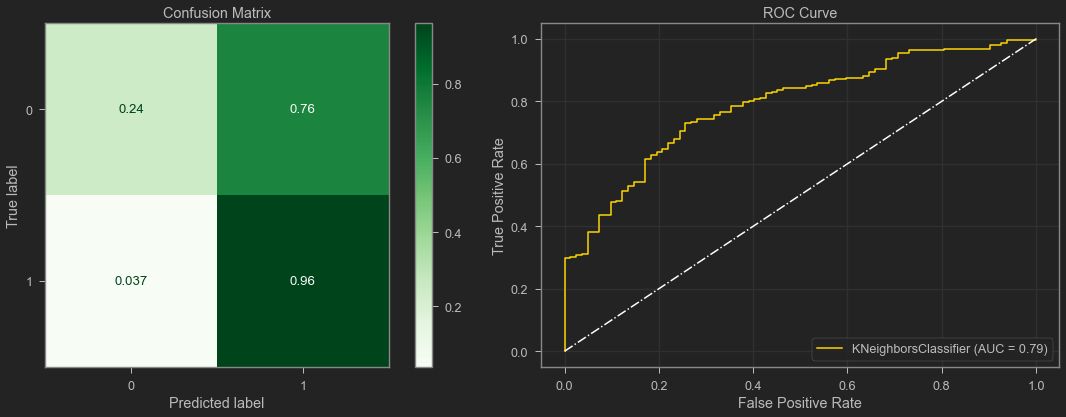

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_knn.fit(X_train_knn, y_train)
print(f"Best Parameters by gridsearch:\t{gridsearch_knn.best_params_}")
print(f"Best Estimator by gridsearch:\t{gridsearch_knn.best_estimator_}")

knn_gs_best = gridsearch_knn.best_estimator_
fun.model_report(knn_gs_best, X_train_knn, y_train, X_test_knn,
             y_test)

## ensemble methods

In [48]:
X_train_xg = fun.df_preprocessing_pipeline(X_train).copy()
X_test_xg = fun.df_preprocessing_pipeline(X_test).copy()

### Random forest

In [49]:
rf_clf = RandomForestClassifier()

******************************************************************************************
Train score: 1.0
Test score: 0.8167
    Possible Overfitting, diffrence of scores 18.33% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    RandomForestClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.63      0.65        82
           1       0.87      0.89      0.88       218

    accuracy                           0.82       300
   macro avg       0.77      0.76      0.76       300
weighted avg       0.81      0.82      0.81       300

************************************************************


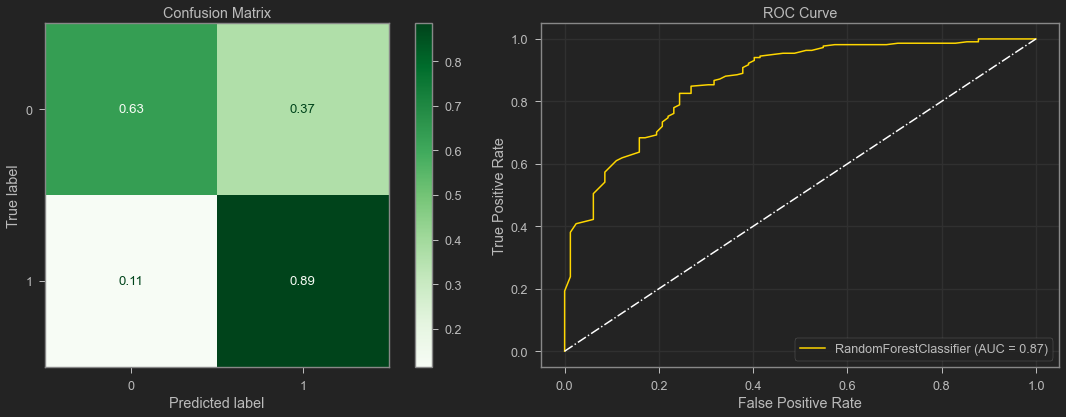

In [50]:
fun.model_report(rf_clf, X_train_xg, y_train, X_test_xg,
             y_test)

### XGBClassifier

******************************************************************************************
Train score: 0.9944
Test score: 0.81
    Possible Overfitting, diffrence of scores 18.44% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
------------------------------

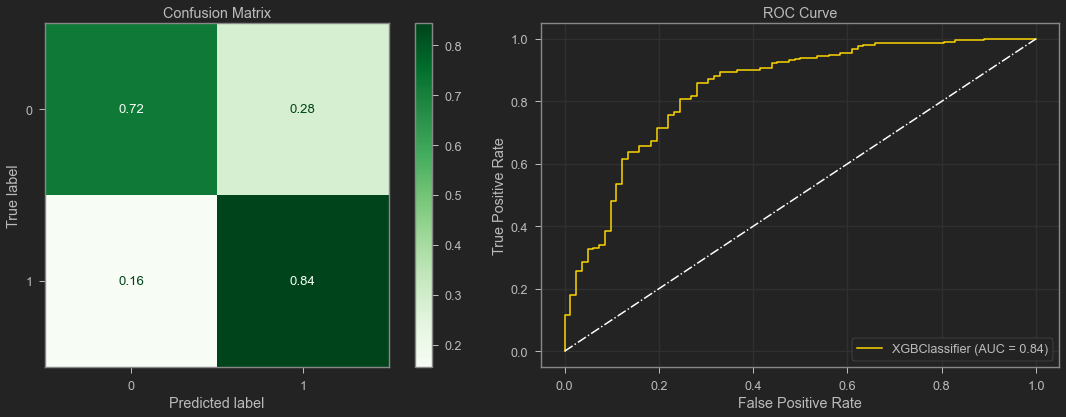

In [51]:
xgg_clf = XGBClassifier()
fun.model_report(xgg_clf, X_train_xg, y_train, X_test_xg,
             y_test)

### XGBRFClassifier

******************************************************************************************
Train score: 0.8685
Test score: 0.81
    Possible Overfitting, diffrence of scores 5.8500000000000005% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)
--------------------------------------------

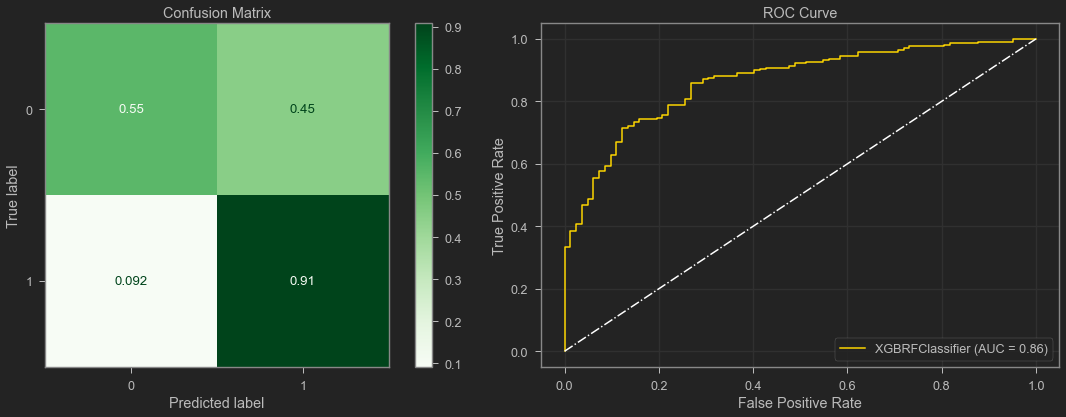

In [52]:
xgg_rf_clf = XGBRFClassifier()
fun.model_report(xgg_rf_clf, X_train_xg, y_train, X_test_xg,
             y_test)

## SVM

In [53]:
X_train_svm = fun.df_preprocessing_pipeline(X_train).copy()
X_test_svm = fun.df_preprocessing_pipeline(X_test).copy()

### lin

******************************************************************************************
Train score: 0.7135
Test score: 0.67
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    SVC(C=1, class_weight='balanced', kernel='linear')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.71      0.54        82
           1       0.86      0.66      0.74       218

    accuracy                           0.67       300
   macro avg       0.65      0.68      0.64       300
weighted avg       0.74      0.67      0.69       300

************************************************************


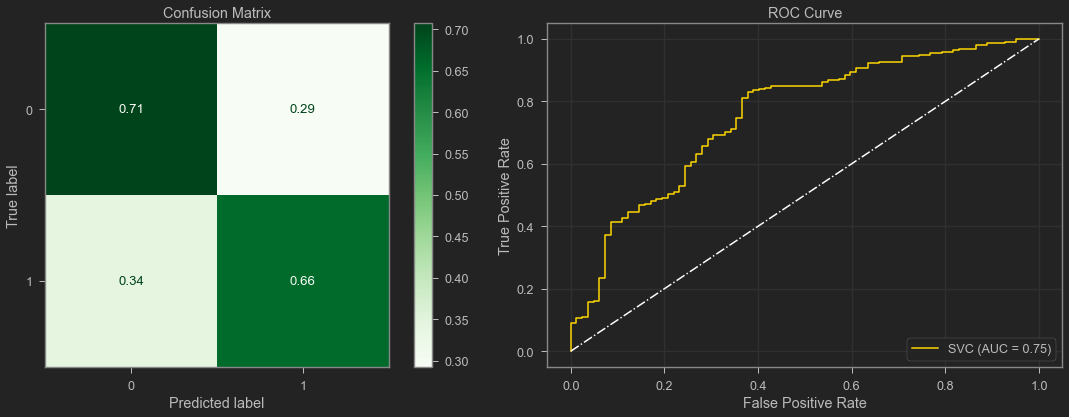

In [54]:
svc_linear = SVC(kernel='linear', C=1,class_weight='balanced')
fun.model_report(svc_linear, X_train_svm, y_train, X_test_svm,
             y_test)

### rbf

******************************************************************************************
Train score: 0.7804
Test score: 0.7267
    Possible Overfitting, diffrence of scores 5.37% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    SVC(C=1, class_weight='balanced')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.68      0.58        82
           1       0.86      0.74      0.80       218

    accuracy                           0.73       300
   macro avg       0.68      0.71      0.69       300
weighted avg       0.76      0.73      0.74       300

************************************************************


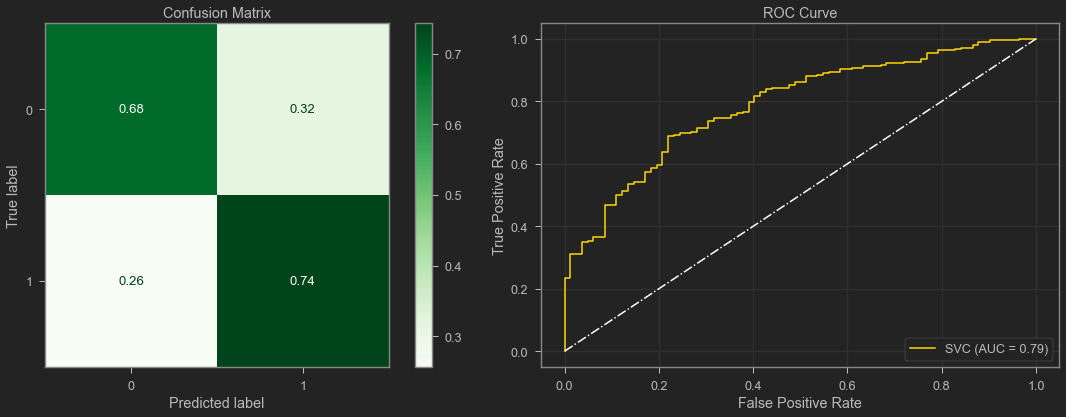

In [55]:
svc_rbf = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
fun.model_report(svc_rbf, X_train_svm, y_train, X_test_svm,
             y_test)

### poly 

******************************************************************************************
Train score: 0.8116
Test score: 0.73
    Possible Overfitting, diffrence of scores 8.16% crossed 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    SVC(C=1, class_weight='balanced', degree=8, kernel='poly')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.52      0.51        82
           1       0.82      0.81      0.81       218

    accuracy                           0.73       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.73      0.73      0.73       300

************************************************************


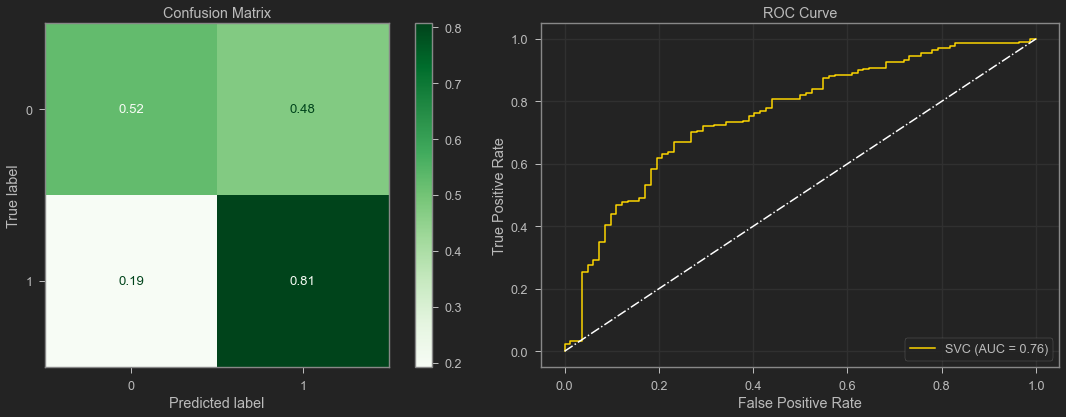

In [56]:
svc_poly = SVC(kernel='poly',
               degree=8,
               C=1,
               gamma='scale',
               class_weight='balanced')
fun.model_report(svc_poly, X_train_svm, y_train, X_test_svm,
             y_test)

### sigmoid

******************************************************************************************
Train score: 0.6109
Test score: 0.6033
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report of:
    SVC(C=2, class_weight='balanced', kernel='sigmoid')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.70      0.49        82
           1       0.83      0.57      0.68       218

    accuracy                           0.60       300
   macro avg       0.60      0.63      0.58       300
weighted avg       0.71      0.60      0.62       300

************************************************************


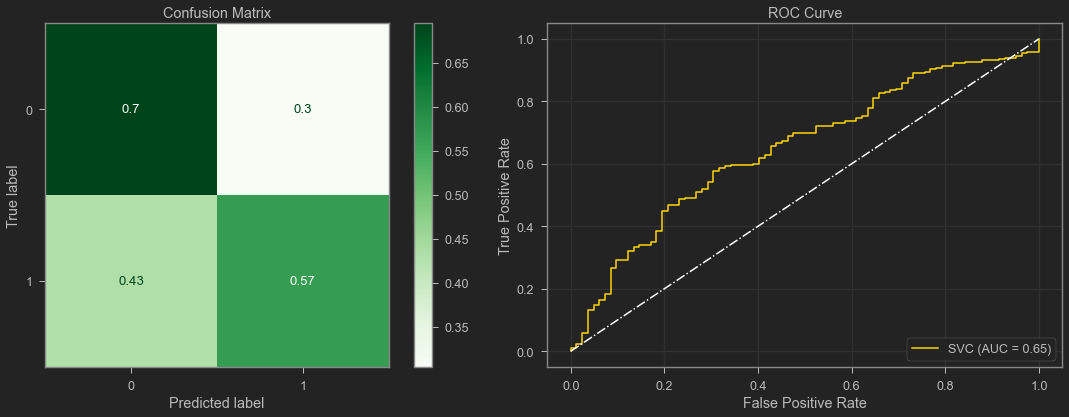

In [57]:
svc_sig = SVC(kernel='sigmoid', C=2, class_weight='balanced')
fun.model_report(svc_sig, X_train_svm, y_train, X_test_svm,
             y_test)

# INTERPRET

# RECOMMENDATION

# NEXT STEPS

# APPENDIX

## all functions from the `functions.py`

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, QuantileTransformer, PowerTransformer, MaxAbsScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from IPython.display import display, HTML
from sklearn import metrics


def check_NaN(df):
    """
    Checks for NaN in the pandas DataFrame and spits a DataFrame of report.
    Uses df.isnull() method.
    
    Parameters:
    ===========
    df = pandas.DataFrame

    ---version 0.9---
    """
    null_checking = []
    for column in df.columns:
        not_null = df[column].isnull().value_counts()[0]
        try:
            is_null = df[column].isnull().value_counts()[1]
        except:
            is_null = 0
        temp_dict = {'name': column, 'is_null': is_null, 'not_null': not_null}
        null_checking.append(temp_dict)
    df_ = pd.DataFrame(null_checking)
    return df_


def check_duplicates(df, verbose=False, limit_output=True, limit_num=150):
    """
    Checks for duplicates in the pandas DataFrame and return a Dataframe of report.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    verbose = `int` or `boolean`; default: `False`
                `True` returns DataFrame with details of features.
                `False` returns DataFrame without details of features.
    limit_output = `int` or `boolean`; default: `True`
                `True` limits featurs display to 150.
                `False` details of unique features.
    limit_num = `int`, limit number of uniques; default: 150,

    ---version 1.2---
    """
    dup_checking = []
    for column in df.columns:
        not_duplicated = df[column].duplicated().value_counts()[0]
        try:
            duplicated = df[column].duplicated().value_counts()[1]
        except:
            duplicated = 0
        temp_dict = {
            'name': column,
            'duplicated': duplicated,
            'not_duplicated': not_duplicated
        }
        dup_checking.append(temp_dict)
    df_ = pd.DataFrame(dup_checking)

    if verbose:
        if limit_output:
            for col in df:
                if (len(df[col].unique()))<=limit_num:
                    print(f"{col} >> number of uniques: {len(df[col].unique())}\n{df[col].unique()}")
                else:
                    print(f"{col} >> number of uniques: {len(df[col].unique())}, showing top {limit_num} values\n{df[col].unique()[:limit_num]}")
                print(f"{'_'*60}")
        else:
            for col in df:
                print(f"{col} >> number of uniques: {len(df[col].unique())}\n{df[col].unique()}")
    return df_


def num_col_for_plotting(row, col=3):
    """
    +++ formatting helper function +++
    __________________________________
    Returns number of rows to plot
    
    Parameters:
    ===========
    row = int;
    col = int; default col: 3
    """
    if row % col != 0:
        return (row // col) + 1
    else:
        return row // col


def df_distribution(df, n_cols=3, fig_size=(16, 26), color_plot='gold', kde_show=True, label_rotation=45):
    """
    Parameters:
    ===========
    df          = pandas.DataFrame,
    n_cols      = int; default: 3,
                    controls number of columns per row of the figure.
    fig_size    = tuple (length, height); default: (16, 26),
                    controls the figure size of the output. 
    color_plot  = str; default: 'gold',
                    controls color of the histplot and kde plot.
    kde_show    = `int` or `boolean`; default: `True`,
                    `True` shows kde plot.
                    `False` does not show kde plot.
    label_rotation = int; default: 45,
                    sets x label rotation.
    
    ---version 1.1---
    """
    fig, axes = plt.subplots(nrows=num_col_for_plotting(len(df.columns),
                                                        col=n_cols),
                             ncols=n_cols,
                             figsize=fig_size,
                             sharey=False)
    for ax, column in zip(axes.flatten(), df):
        sns.histplot(x=column, data=df, color=color_plot, ax=ax, kde=kde_show)
        ax.set_title(f'Histplot of {column.title()}')
        ax.tick_params('x', labelrotation=label_rotation)
        sns.despine()
        plt.tight_layout()
        plt.suptitle('Histogram plots of the dataset',
                     fontsize=20,
                     fontweight=3,
                     va='bottom')


def df_preprocessing_pipeline(df, scaler=StandardScaler(), drop=None):
    """
    Seperates DataFrame by categorical and numerical coulmns, and performs OneHotEncoding with droping control on categorical coulumns and scaling on numerical columns, user can select scalers. Then returns a transformed DataFrame.
    All steps are done using sklearn pipelines and transformers. 
    
    Parameters:
    ===========
    df     = pandas.DataFrame object.
    scaler = sklarn scaler object; default: StandardScaler(),
                *** IMPORT desired scaler before using. ***
                *** OR call with this module. all of them are imported and ready 
                to use inside this module.***
                Available options:
                - StandardScaler: removes the mean and scales the data to 
                    unit variance. 
                - MinMaxScaler: rescales the data set such that all feature 
                    values are in the range [0, 1]
                - RobustScaler: is based on percentiles and are therefore not
                    influenced by a few number of very large marginal outliers.
                - QuantileTransformer: applies a non-linear transformation 
                    such that the probability density function of each feature
                    will be mapped to a uniform or Gaussian distribution.
                - PowerTransformer: applies a power transformation to each 
                    feature to make the data more Gaussian-like in order to 
                    stabilize variance and minimize skewness.
                - MaxAbsScaler: is similar to `MinMaxScaler` except that the
                    values are mapped in the range [0, 1]
                - Normalizer: rescales the vector for each sample to have 
                    unit norm, independently of the distribution of the samples.
    drop   = str or `None`, Option to control OHE droping; default: None.
                - None : retain all features (the default).
                - 'first' : drop the first category in each feature. If only one
                  category is present, the feature will be dropped entirely.
                - 'if_binary' : drop the first category in each feature with two
                  categories. Features with 1 or more than 2 categories are
                  left intact.
                - array : ``drop[i]`` is the category in feature ``X[:, i]`` that
                  should be dropped.
    
    Next steps: use OOP to make this a class.

    ---version 0.9.1---
    """
    # isolating numerical features
    nume_cols = df.select_dtypes('number').columns.to_list()
    # isolating categorical features
    cate_cols = df.select_dtypes('category').columns.to_list()
    # pipeline for processing categorical features
    pipe_cate = Pipeline([('ohe', OneHotEncoder(sparse=False, drop=drop))])
    # pipeline for processing numerical features
    pipe_nume = Pipeline([('scaler', scaler)])
    # Coulmn transformer
    preprocessor = ColumnTransformer([
        ('numerical_features', pipe_nume, nume_cols),
        ('categorical_features', pipe_cate, cate_cols)
    ])
    # creating a pandas.DataFrame with appropriate header
    ret = pd.DataFrame(
        preprocessor.fit_transform(df),
        columns=nume_cols +
        preprocessor.named_transformers_['categorical_features'].
        named_steps['ohe'].get_feature_names(cate_cols).tolist())
    return ret

def coefficients_of_model_binary(model,X_train_data, log_scale=True):
    """
    Returns a pandas.Series object with intercept and coeffients of a logistic regression model with features as index
    
    Parameters:
    ===========
    model        = object; No Default. 
                    fitted sklearn model object with a coef_ and intercept_ attribute.
    X_train_data = pandas.DataFrame; No Default.
                    DataFrame of independant variables. Should be train-test splitted. 
                    Use train data.  
    log_scale    = boolean; default: True.
                    `True` for keeping log scale of coefficients.
                    `False` for converting to normal scale.

    """
    coeffs = pd.Series(model.coef_.flatten(), index=X_train_data.columns)
    coeffs['intercept'] = model.intercept_[0]
    if log_scale is False:
        coeffs = np.exp(coeffs)
    return coeffs

def coefficients_of_model(model,X_train_data,log_scale=True):
    """
    Returns a pandas.Series object with intercept and coeffients.
    Parameters:
    ===========
    model        = object; No Default. 
                    fitted sklearn model object with a coef_ and intercept_ attribute.
    X_train_data = pandas.DataFrame; No Default.
                    DataFrame of independant variables. Should be train-test splitted. 
                    Use train data.  
    log_scale    = boolean; default: True.
                    `True` for keeping log scale of coefficients.
                    `False` for converting to normal scale.

    """
    coeffs = pd.Series(model.coef_.flatten())
    coeffs['intercept'] = model.intercept_[0]
    if log_scale is False:
        coeffs = np.exp(coeffs)
    return coeffs

def model_report(model,
                 X_train,
                 y_train,
                 X_test,
                 y_test,
                 cmap='Greens',
                 normalize='true',
                 figsize=(16, 6)):
    """
    Report of model using train-test split dataset.
    Shows train and test score, Confusion Matrix of test data and, ROC Curve of test data.
    
    Parameters:
    ===========
    model     = object, scikit-learn model object; no default.
    X_train   = pandas.DataFrame, predictor variable training data split; no default,
    y_train   = pandas.DataFrame, target variable training data split; no default,
    X_test    = pandas.DataFrame, predictor variable test data split; no default,
    y_test    = pandas.DataFrame, target variable test data split; no default,
    cmap      = str, colormap of Confusion Matrix; default: 'Greens',
    normalize = str, normalize count of Confusion Matrix; default: 'true',
                `true` to normalize.
                `false` to show counts.
    figsize   = tuple ``(lenght, height)``, figsize of output; default: (16, 6),
    
    ---version 0.9---
    """
    
    def str_model_(model):
        """Helper function to get model class display statement, this text conversion breaks code if performed in that local space. This is to isolate from the function local space."""
        str_model = str(model)
        display(
            HTML(
                f"""<strong>Report of {str_model.split('(')[0]} type model using train-test split dataset.</strong>"""
            ))

    str_model_(model)
    model.fit(X_train, y_train)
    print(f"{'*'*90}")
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    print(f"""Train score: {train.round(4)}""")
    print(f"""Test score: {test.round(4)}""")
    if abs(train - test) <= .05:
        print(
            f"    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold."
        )
    elif (train - test) > .05:
        print(
            f"    Possible Overfitting, diffrence of scores {abs(train-test).round(4)*100}% crossed 5% thresh hold."
        )
    elif (train - test) < -.05:
        print(
            f"    Possible Underfitting, diffrence of scores {abs(train-test).round(4)*100}% crossed 5% thresh hold."
        )
    print(f"{'*'*90}")
    print("")
    print(f"{'*'*60}")
    print(f"""Classification report of:
    {model}""")
    print(f"{'-'*60}")
    print(metrics.classification_report(y_test, model.predict(X_test)))
    print(f"{'*'*60}")

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model,
                                  X_test,
                                  y_test,
                                  cmap=cmap,
                                  normalize=normalize,
                                  ax=ax[0])
    ax[0].title.set_text('Confusion Matrix')
    metrics.plot_roc_curve(model,
                           X_test,
                           y_test,
                           color='gold',
                           ax=ax[1])
    ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
    ax[1].grid()
    ax[1].title.set_text('ROC Curve')

    plt.tight_layout()
    plt.show()
```